# `DSML_WS_02` - Data Vipers - `Team Assignment`

Importing the needed Python Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
sns.set_style("white")
#sns.set_palette("GnBu_d")
sns.set_palette("tab10")

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')

import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
import math
import random
from pathlib import Path

import geopy
from geopy.geocoders import GoogleV3
from geopy.distance import geodesic

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from datetime import datetime
from datetime import timedelta

import math
import random

## Task 1 Customer Behavior Analytics:

1) Data Preparation
2) Data Cleaning
3) More Data Preperation
4) Visualizing Data and Distributions
5) Clustering

### 1.1) Data preparation

We are working with the provided dataframe 

Formatting the datetime columns from string to datetime format

In [2]:
df = pd.read_csv("../boston_2016.csv")

weather_data = pd.read_csv("../weather_hourly_boston.csv", encoding = "ISO-8859-1")
tripdata = df

df["start_time"] = pd.to_datetime(df["start_time"],format="%Y-%m-%d %H:%M:%S") # FORMAT %Y-%m-%d %H:%M:%S beachte - und :
df["end_time"] = pd.to_datetime(df["end_time"],format="%Y-%m-%d %H:%M:%S")

In [3]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber


In [4]:
print(len(df["bike_id"].unique()))

1802


In [5]:
df_customer = df.drop(df[df['user_type'] == "Subscriber"].index)
df_subscriber = df.drop(df[df['user_type'] == "Customer"].index)
print("customers:", (len(df_customer)/len(df))*100,'%')
print("subscribers:", (len(df_subscriber)/len(df))*100,'%')

customers: 20.406357208322582 %
subscribers: 79.59364279167742 %


In [6]:
print("unique station names:", len(df["start_station_name"].unique()))

unique station names: 276


In [7]:
print("unique station ID's: ",len(df["start_station_id"].unique()))

unique station ID's:  189


There are redundant station_names in the data frame, therfore we are working with the station ID's as they are unique

We are also taking information from the official BlueBikes Boston dataframes:

https://www.bluebikes.com/system-data

In [8]:
df_bluebikes_01 = pd.read_csv("Bluebikes_Trip_data/201601-hubway-tripdata.csv")
df_bluebikes_02 = pd.read_csv("Bluebikes_Trip_data/201602-hubway-tripdata.csv")
df_bluebikes_03 = pd.read_csv("Bluebikes_Trip_data/201603-hubway-tripdata.csv")
df_bluebikes_04 = pd.read_csv("Bluebikes_Trip_data/201604-hubway-tripdata.csv")
df_bluebikes_05 = pd.read_csv("Bluebikes_Trip_data/201605-hubway-tripdata.csv")
df_bluebikes_06 = pd.read_csv("Bluebikes_Trip_data/201606-hubway-tripdata.csv")
df_bluebikes_07 = pd.read_csv("Bluebikes_Trip_data/201607-hubway-tripdata.csv")
df_bluebikes_08 = pd.read_csv("Bluebikes_Trip_data/201608-hubway-tripdata.csv")
df_bluebikes_09 = pd.read_csv("Bluebikes_Trip_data/201609-hubway-tripdata.csv")
df_bluebikes_10 = pd.read_csv("Bluebikes_Trip_data/201610-hubway-tripdata.csv")
df_bluebikes_11 = pd.read_csv("Bluebikes_Trip_data/201611-hubway-tripdata.csv")
df_bluebikes_12 = pd.read_csv("Bluebikes_Trip_data/201612-hubway-tripdata.csv")

In [9]:
df_bluebikes_all = pd.concat([df_bluebikes_01, 
                            df_bluebikes_02,
                            df_bluebikes_03,
                            df_bluebikes_03,
                            df_bluebikes_04,
                            df_bluebikes_05,
                            df_bluebikes_06,
                            df_bluebikes_07,
                            df_bluebikes_08,
                            df_bluebikes_09,
                            df_bluebikes_10,
                            df_bluebikes_11,
                            df_bluebikes_12], axis=0)

In [10]:
print(len(df_bluebikes_all["start station id"].unique()))

189


the amount of unique station ID's matches the one from our data frame

We are using the following data from these dataframes:
- start station latitude
- end station latitude
- start station longitude
- end station longitude

from all unique stations (189 in total)

In [11]:
df_bluebikes_all.drop(['tripduration','starttime','stoptime','end station id', 'end station name', 'end station latitude','end station longitude', 'bikeid', 'usertype', 'birth year','gender'], axis=1, inplace=True)

df_bluebikes_all.rename(columns = {'start station id':'start_station_id'}, inplace = True)
df_bluebikes_all.rename(columns = {'start station latitude':'start_station_latitude'}, inplace = True)
df_bluebikes_all.rename(columns = {'start station longitude':'start_station_longitude'}, inplace = True)
df_bluebikes_all.rename(columns = {'start station name':'start_station_name'}, inplace = True)

df_bluebikes_all.sort_values(["start_station_id"],axis=0, ascending=True,inplace=True,na_position='first')
df_bluebikes_all = df_bluebikes_all.drop_duplicates(subset=['start_station_id'])

df_stations = df_bluebikes_all

We are exporting this as "all_station_id.csv" file for easier access.

In [12]:
# filepath = Path('C:/Users/rfrei/Desktop/all_station_id.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# df_stations.to_csv(filepath)

In [13]:
df_stations = df_stations.reset_index()
df_stations.drop(['index'], axis=1, inplace=True)


In [14]:
df_stations.head(1)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude
0,1,18 Dorrance Warehouse,42.387151,-71.075978


Now we are mapping the lat, long of start and end station to our dataframe (warning: this process might be a bit unorthodox but it is working).

In [15]:
df["start_lat"] = pd.to_numeric(df["start_station_id"], downcast="float")
df["start_long"] = pd.to_numeric(df["start_station_id"], downcast="float")
df["end_lat"] = pd.to_numeric(df["end_station_id"], downcast="float")
df["end_long"] = pd.to_numeric(df["end_station_id"], downcast="float")

The columns above are placeholders.

They are used for the  replace methods which are going to place the correct lat, long to the specific row with the matching station ID.

Because we only have 189 stations we were able to prepare the matching ID's and lat, long in a rather manual fasion. But this way it is also very effecient. 

In [16]:
df['start_lat'] = df['start_lat'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[42.387151,42.340021,42.345392,42.341814,42.361174,42.35328743453294,42.353334,42.351246,42.350406,42.338629,42.335911,42.336437,42.337171,42.361667,42.34807412317439,42.365064,42.347241,42.35977,42.345959,42.352175,42.35892,42.351205,42.341332,42.341522,42.331184,42.363732,42.334073,42.348833,42.34519428944095,42.348706,42.355402,42.349673,42.357402,42.366222,42.33849279283789,42.363871,42.352261,42.352033,42.357143,42.360613,42.344706,42.343864,42.362811,42.356755,42.351146,42.350989,42.3348756,42.34872432400896,42.350851,42.354979,42.347265,42.328654,42.340799,42.355596,42.351356,42.360624982690496,42.348762,42.344023,42.3511,42.3475,42.348607,42.3581,42.36507,42.341598,42.37199165408676,42.383405,42.362613,42.373231,42.373268,42.36346469304347,42.366426,42.386844,42.379637,42.37842,42.3619622,42.352409,42.339335,42.366981,42.378338,42.366621,42.374035,42.379011,42.370677,42.366277,42.3139036,42.320494,42.375603,42.372969,42.373379,42.36919031768079,42.371848,42.385582,42.396969,42.400877,42.346563,42.380287,42.357218503176526,42.325333,42.3625,42.377945,42.36588481543564,42.376369,42.40449,42.39082,42.330716,42.402763,42.387995,42.370803,42.366095,42.397828,42.335741,42.356052,42.335693,42.345733,42.309054,42.320998,42.315692,42.320561,42.377022,42.31756858003556,42.322701,42.310579,42.350413,42.344827,42.344796,42.398365,42.326599,42.361589,42.388966,42.36356015842989,42.396105,42.369885,42.392766,42.336448,42.363796,42.344137,42.358155,42.345901,42.3601,42.3601,42.32797270205962,42.337596,42.3391085,42.309796,42.344792,42.317642,42.378965,42.303469,42.37408991426522,42.310599,42.34900494405213,42.34894857235593,42.38674802045056,42.36264779118595,42.35957320109044,42.35560121327927,42.37478628706384,42.39558845716709,42.35775309465199,42.36544486137399,42.3482032222746,42.3624278429124,42.36559770612416,42.354686,42.33289074055233,42.38614141163957,42.3720597013741,42.31787329345602,42.321678,42.31884382360106,42.33282815812448,42.316873,42.308035,42.309566,42.324069,42.30791912678712,42.35480179069945,42.35057,42.37980321246644,42.38337841883669,42.36489045541549,42.3688385713652,42.369562869377,42.37536686015489,42.37078454600501,42.38244736415864,42.38673178529929,42.351586001198456,42.37430131617823])

In [17]:
df['start_long'] = df['start_long'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[-71.075978,-71.100812,-71.069616,-71.090179,-71.065142,-71.04438900947571,-71.137313,-71.115639,-71.108279,-71.1065,-71.088496,-71.073089,-71.102797,-71.13802,-71.07657015323639,-71.119233,-71.105301,-71.051601,-71.082578,-71.055547,-71.057629,-71.043983,-71.076847,-71.068922,-71.095171,-71.124565,-71.105221,-71.041747,-71.1016970872879,-71.097009,-71.058087,-71.077303,-71.147782,-71.059914,-71.07401937246323,-71.050877,-71.123831,-71.070627,-71.050699,-71.057452,-71.097515,-71.085918,-71.056067,-71.055407,-71.066289,-71.073644,-71.0790969,-71.08583986759186,-71.089886,-71.063348,-71.088088,-71.084198,-71.081572,-71.07278,-71.059367,-71.0708999633789,-71.082383,-71.057054,-71.0496,-71.0441,-71.13401,-71.093198,-71.1031,-71.123338,-71.12226963043213,-71.107593,-71.084105,-71.120886,-71.118579,-71.10057324171066,-71.105495,-71.09812,-71.095319,-71.105668,-71.0920526,-71.062679,-71.13493,-71.076472,-71.048927,-71.114214,-71.101427,-71.119945,-71.076529,-71.09169,-71.0405121,-71.051122,-71.064608,-71.094445,-71.111075,-71.11714124679565,-71.060292,-71.113341,-71.123024,-71.116772,-71.128374,-71.125107,-71.1138716340065,-71.075354,-71.08822,-71.116865,-71.06454849243164,-71.114025,-71.123413,-71.10942,-71.057044,-71.126908,-71.119084,-71.104412,-71.086388,-71.130516,-71.03877,-71.069849,-71.045859,-71.100694,-71.11543,-71.110833,-71.098634,-71.06198,-71.056605,-71.06403708501603,-71.099533,-71.107341,-71.07655,-71.028664,-71.031614,-71.107818,-71.066498,-71.107437,-71.132788,-71.08216792345047,-71.139459,-71.069957,-71.129042,-71.023739,-71.129164,-71.052608,-71.052163,-71.063187,-71.0589,-71.0589,-71.11089706420898,-71.096391,-71.0514432,-71.092225,-71.044024,-71.056664,-71.068607,-71.085347,-71.06905996799469,-71.053927,-71.1604106426239,-71.15027189254761,-71.11901879310608,-71.10006093978882,-71.10129475593567,-71.10394477844238,-71.13320231437683,-71.14260613918304,-71.10393404960632,-71.08277142047882,-71.0376513004303,-71.08495473861694,-71.06424808502197,-71.053292,-71.11658334732056,-71.07828140258789,-71.07202649116516,-71.08243077993393,-71.091822,-71.06975734233856,-71.08126938343048,-71.091955,-71.081159,-71.072863,-71.083162,-71.06502056121826,-71.15025043487549,-71.166491,-71.02744817733765,-71.01612031481636,-71.0350424052376,-71.03976666949166,-71.03942692279814,-71.03135883808136,-71.04426160454749,-71.0302323102951,-71.00621223455164,-71.04569256305693,-71.03808671246952])

In [18]:
df['end_lat'] = df['end_lat'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[42.387151,42.340021,42.345392,42.341814,42.361174,42.35328743453294,42.353334,42.351246,42.350406,42.338629,42.335911,42.336437,42.337171,42.361667,42.34807412317439,42.365064,42.347241,42.35977,42.345959,42.352175,42.35892,42.351205,42.341332,42.341522,42.331184,42.363732,42.334073,42.348833,42.34519428944095,42.348706,42.355402,42.349673,42.357402,42.366222,42.33849279283789,42.363871,42.352261,42.352033,42.357143,42.360613,42.344706,42.343864,42.362811,42.356755,42.351146,42.350989,42.3348756,42.34872432400896,42.350851,42.354979,42.347265,42.328654,42.340799,42.355596,42.351356,42.360624982690496,42.348762,42.344023,42.3511,42.3475,42.348607,42.3581,42.36507,42.341598,42.37199165408676,42.383405,42.362613,42.373231,42.373268,42.36346469304347,42.366426,42.386844,42.379637,42.37842,42.3619622,42.352409,42.339335,42.366981,42.378338,42.366621,42.374035,42.379011,42.370677,42.366277,42.3139036,42.320494,42.375603,42.372969,42.373379,42.36919031768079,42.371848,42.385582,42.396969,42.400877,42.346563,42.380287,42.357218503176526,42.325333,42.3625,42.377945,42.36588481543564,42.376369,42.40449,42.39082,42.330716,42.402763,42.387995,42.370803,42.366095,42.397828,42.335741,42.356052,42.335693,42.345733,42.309054,42.320998,42.315692,42.320561,42.377022,42.31756858003556,42.322701,42.310579,42.350413,42.344827,42.344796,42.398365,42.326599,42.361589,42.388966,42.36356015842989,42.396105,42.369885,42.392766,42.336448,42.363796,42.344137,42.358155,42.345901,42.3601,42.3601,42.32797270205962,42.337596,42.3391085,42.309796,42.344792,42.317642,42.378965,42.303469,42.37408991426522,42.310599,42.34900494405213,42.34894857235593,42.38674802045056,42.36264779118595,42.35957320109044,42.35560121327927,42.37478628706384,42.39558845716709,42.35775309465199,42.36544486137399,42.3482032222746,42.3624278429124,42.36559770612416,42.354686,42.33289074055233,42.38614141163957,42.3720597013741,42.31787329345602,42.321678,42.31884382360106,42.33282815812448,42.316873,42.308035,42.309566,42.324069,42.30791912678712,42.35480179069945,42.35057,42.37980321246644,42.38337841883669,42.36489045541549,42.3688385713652,42.369562869377,42.37536686015489,42.37078454600501,42.38244736415864,42.38673178529929,42.351586001198456,42.37430131617823])

In [19]:
df['end_long'] = df['end_long'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[-71.075978,-71.100812,-71.069616,-71.090179,-71.065142,-71.04438900947571,-71.137313,-71.115639,-71.108279,-71.1065,-71.088496,-71.073089,-71.102797,-71.13802,-71.07657015323639,-71.119233,-71.105301,-71.051601,-71.082578,-71.055547,-71.057629,-71.043983,-71.076847,-71.068922,-71.095171,-71.124565,-71.105221,-71.041747,-71.1016970872879,-71.097009,-71.058087,-71.077303,-71.147782,-71.059914,-71.07401937246323,-71.050877,-71.123831,-71.070627,-71.050699,-71.057452,-71.097515,-71.085918,-71.056067,-71.055407,-71.066289,-71.073644,-71.0790969,-71.08583986759186,-71.089886,-71.063348,-71.088088,-71.084198,-71.081572,-71.07278,-71.059367,-71.0708999633789,-71.082383,-71.057054,-71.0496,-71.0441,-71.13401,-71.093198,-71.1031,-71.123338,-71.12226963043213,-71.107593,-71.084105,-71.120886,-71.118579,-71.10057324171066,-71.105495,-71.09812,-71.095319,-71.105668,-71.0920526,-71.062679,-71.13493,-71.076472,-71.048927,-71.114214,-71.101427,-71.119945,-71.076529,-71.09169,-71.0405121,-71.051122,-71.064608,-71.094445,-71.111075,-71.11714124679565,-71.060292,-71.113341,-71.123024,-71.116772,-71.128374,-71.125107,-71.1138716340065,-71.075354,-71.08822,-71.116865,-71.06454849243164,-71.114025,-71.123413,-71.10942,-71.057044,-71.126908,-71.119084,-71.104412,-71.086388,-71.130516,-71.03877,-71.069849,-71.045859,-71.100694,-71.11543,-71.110833,-71.098634,-71.06198,-71.056605,-71.06403708501603,-71.099533,-71.107341,-71.07655,-71.028664,-71.031614,-71.107818,-71.066498,-71.107437,-71.132788,-71.08216792345047,-71.139459,-71.069957,-71.129042,-71.023739,-71.129164,-71.052608,-71.052163,-71.063187,-71.0589,-71.0589,-71.11089706420898,-71.096391,-71.0514432,-71.092225,-71.044024,-71.056664,-71.068607,-71.085347,-71.06905996799469,-71.053927,-71.1604106426239,-71.15027189254761,-71.11901879310608,-71.10006093978882,-71.10129475593567,-71.10394477844238,-71.13320231437683,-71.14260613918304,-71.10393404960632,-71.08277142047882,-71.0376513004303,-71.08495473861694,-71.06424808502197,-71.053292,-71.11658334732056,-71.07828140258789,-71.07202649116516,-71.08243077993393,-71.091822,-71.06975734233856,-71.08126938343048,-71.091955,-71.081159,-71.072863,-71.083162,-71.06502056121826,-71.15025043487549,-71.166491,-71.02744817733765,-71.01612031481636,-71.0350424052376,-71.03976666949166,-71.03942692279814,-71.03135883808136,-71.04426160454749,-71.0302323102951,-71.00621223455164,-71.04569256305693,-71.03808671246952])

From the lat, long we can create new columns with the coordinates.

In [20]:
df["start_coordinates"] = list(zip(df["start_lat"],df["start_long"]))

In [21]:
df["end_coordinates"] = list(zip(df["end_lat"],df["end_long"]))

Now the lat, long columns are not needed anymore.

In [22]:
 df.drop(['start_lat','end_lat','start_long','end_long'], axis=1, inplace=True)

In [23]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)"


Now we are creating new columns for the following trip-level features:
- distance
- duration
- speed

we need the following methods:

In [24]:
def calc_distances(start_point,end_point):
    return geopy.distance.geodesic( start_point, end_point ).km
    
def calc_durations(end_time,start_time):
    return (end_time - start_time).total_seconds()

The distance between start and end station is calculated using the geopy function.
This gives us the bee-line between two stations. Trips where start and end are equal will therefore have a distance of 0km. (This takes a few minutes)

In [25]:
df['distance_km'] = df.apply(lambda row: calc_distances(row.start_coordinates, row.end_coordinates), axis=1)

The duration can be calculated from the earlier formatted start and end time stamps.

In [26]:
df["duration_sec"] = df.apply(lambda row: calc_durations(row.end_time,row.start_time), axis=1)

Now we can calculate the average speed of each trip and add this feature to the data frame:

In [27]:
df["speed_kmh"] = (df["distance_km"]/(df["duration_sec"]/3600))

In [28]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1939.0,4.312426


Now we can calculate some interesting values:

In [29]:
df_station_to_station = df.drop(df[df['distance_km'] == 0].index)
df_roundtrip = df.drop(df[df['distance_km'] != 0].index)
print("station_to_station:", (len(df_station_to_station)/len(df))*100,'%')
print("roundtrips:", (len(df_roundtrip)/len(df))*100,'%')

station_to_station: 96.8742997711541 %
roundtrips: 3.1257002288459095 %


In [30]:
average_speed = round(df[df["speed_kmh"] != 0]["speed_kmh"].mean(),4)
print("average_speed: ",average_speed, "km/h")

average_speed:  9.761 km/h


In [31]:
average_distance = round(df[df["distance_km"] != 0]["distance_km"].mean(),4)
print("average_distance: ",average_distance, "km")

average_distance:  1.9249 km


In [32]:
average_duration = round(df[df["duration_sec"] != 0]["duration_sec"].mean(),4)
average_duration = round(average_duration/60,4)
print("average_duration: ", average_duration  ,"min") 

average_duration:  22.7537 min


In [33]:
# filepath = Path('C:/Users/rfrei/Desktop/boston_2016_distance_duration_speed.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# df.to_csv(filepath)

### 1.2) Data Cleaning

Now we are taking a look at the data and will clean up any errors that might come from bluebikes' data

The station with name "8D OPS 01" and "8D OPS 03" must be a system error:

8D OPS 01 (ID: 158) has the coordinates 45.505086,-73.566921 - which is in canada

8D OPS 03 (ID: 153) has the coordinates 0,0 - which is in the atlantic ocean

we are deleting trips that inlcude these stations:

In [34]:
len(df)

1236203

In [35]:
df = df.drop(df[df['start_station_id'] == 158].index)
df = df.drop(df[df['start_station_id'] == 153].index)
df = df.drop(df[df['end_station_id'] == 158].index)
df = df.drop(df[df['end_station_id'] == 153].index)

print("df: ",len(df))
print("df_stations: ",len(df_stations))

df:  1236200
df_stations:  189


We have decided that any average speed above 30 km/h can not be achieved with a rental bike in city traffic, therefore we are deleting those:

In [36]:
df = df.drop(df[df['speed_kmh'] > 30].index)
len(df)

1236192

Trips with an average negative speed also don't make sense - we are deleting them:

In [37]:
df = df.drop(df[df['speed_kmh'] < 0].index)
len(df)

1236189

In [38]:
df_45 = df.drop(df[df['duration_sec'] > 2700].index)
df_45_plus = df.drop(df[df['duration_sec'] <= 2700].index)
df_120 = df.drop(df[df['duration_sec'] > 7200].index)
df_28800 = df.drop(df[df['duration_sec'] > 28800].index)

In [39]:
print("df_45:", (len(df_45)/len(df))*100,'%')

df_45: 96.97869824112657 %


In [40]:
print("df_45_plus:", (len(df_45_plus)/len(df))*100,'%')

df_45_plus: 3.021301758873441 %


In [41]:
print("df_120:", (len(df_120)/len(df))*100,'%')

df_120: 99.30212936694956 %


Because of the pricing structure which makes trips over 2 hours expensive for the user and the fact that only 0.7% of the trips are longer than 2 hours, we are deleting all trips that are longer than 2 hours.

In [42]:
df = df.drop(df[df['duration_sec'] > 7200].index)
len(df)

1227562

### 1.3) More Data preparation

Now we are preparing the data with visualization and clustering in mind.

#### df_stations

##### Trips per Station

In [43]:
Trips_per_Station = []

Since we got the length of our dataframe, we can count how many departures we are now able to use a lambda function to understand the departures at the individual stations.

In [44]:
for i in df_stations.start_station_id:
    Trip = (df.where(lambda x: (x.start_station_id == i), axis = 0))
    Trips_per_Station.append(len(df) - Trip['start_station_id'].isnull().sum())

In [45]:
print(Trips_per_Station)

[74, 4665, 8922, 7045, 11635, 4560, 4131, 9464, 9558, 8553, 7971, 7768, 8758, 2607, 14985, 6549, 7208, 10844, 12002, 31348, 14462, 7673, 8399, 7952, 4999, 3717, 6275, 5356, 9205, 13823, 9417, 16467, 1310, 9013, 9213, 10786, 8588, 13813, 11014, 7732, 10072, 13168, 13882, 8012, 7637, 8539, 2837, 9161, 17033, 11576, 11953, 1486, 775, 14162, 7924, 15722, 12729, 3326, 9619, 2953, 5052, 35504, 24018, 6206, 8731, 5773, 10614, 11685, 22996, 11417, 14216, 2180, 5519, 6466, 21120, 10378, 2910, 9090, 5343, 10331, 13124, 7846, 12006, 14615, 1051, 1508, 5484, 11425, 10009, 9777, 11304, 3513, 10388, 2254, 3207, 6386, 12251, 508, 14347, 8583, 12726, 9431, 1706, 1365, 2441, 3213, 10187, 9685, 7140, 5475, 4002, 8718, 4823, 3581, 2418, 2642, 1044, 1042, 2470, 719, 3693, 2826, 5933, 3405, 4365, 1606, 932, 6148, 2875, 6613, 3085, 6264, 1874, 2987, 6223, 5141, 7551, 6481, 0, 0, 1730, 4653, 5017, 368, 4912, 1071, 2858, 414, 2388, 497, 999, 1971, 3296, 11712, 15196, 17430, 2391, 385, 779, 564, 4669, 17944, 8

To check for completeness, we compare the length of the array with the number of unique stations.

In [46]:
len(Trips_per_Station)

189

Since this is the case, we can enter the 189 entries directly into the dataframe of the stations.

In [47]:
df_stations['amout_of_trips_per_station'] = Trips_per_Station

In [48]:
sum(df_stations['amout_of_trips_per_station'])

1227562

Here you can also clearly see the high demand for students.

The most used station is one at MIT

In [49]:
df_stations.sort_values(['amout_of_trips_per_station'],axis=0, ascending=False,inplace=True,na_position='first')

In [50]:
df_stations.head(5)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,amout_of_trips_per_station
61,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,35504
19,22,South Station - 700 Atlantic Ave.,42.352175,-71.055547,31348
62,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,24018
68,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,22996
74,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,21120


In [51]:
df_stations.sort_index(inplace=True)

##### Dinstance from city center

In [52]:
df_stations["start_coordinates"] = list(zip(df_stations["start_station_latitude"],df_stations["start_station_longitude"]))

In [53]:
center_point = (42.36041042227672,-71.05799197093351)
type(center_point)

tuple

In [54]:
def calc_distances_from_center(start_coordinates):
    return geopy.distance.geodesic( start_coordinates,center_point).km

In [55]:
df_stations['distance_center_(km)'] = df_stations.apply(lambda row: calc_distances_from_center(row.start_coordinates), axis=1)

In [56]:
df_stations.sort_index(inplace=True)
df_stations.head(1)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,amout_of_trips_per_station,start_coordinates,distance_center_(km)
0,1,18 Dorrance Warehouse,42.387151,-71.075978,74,"(42.387151, -71.075978)",3.319275


#### df

For the clustering we are creating two new features: 
- start station distance from the city center
- end station distance from the city center

These are very useful for determining where a trip has started and ended.

We are again using these "manual" replace methods as we only have to add 187 unique values: 

In [57]:
df["start_distance_center"] = pd.to_numeric(df["start_station_id"], downcast="float")
df['start_distance_center'] = df['start_distance_center'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[3.319274536957586,4.1925465912009425,1.9236113959222407,3.36158328176426,0.5951027715279874,1.3718584965133345,6.582064660303654,4.8572719961183815,4.289507334305973,4.672127506031023,3.704521116556498,2.939187826624499,4.5047893609953515,6.594248754784122,2.05442487758448,5.071361349287967,4.1632693962289435,0.5312852924906886,2.584610624890342,0.9367073810973997,0.16823530294678202,1.5419749489568133,2.627668711831343,2.283235338944895,4.463751921350105,5.4966454730103536,4.8686322934192905,1.8561230946642178,3.9778788149267386,3.4675472072013167,0.5563918225967195,1.9884360834105614,7.404767049772989,0.6646853696629188,2.7697110629371102,0.7009346465441912,5.4992924676229915,1.3962653004526964,0.7019381593422324,0.04985126119504434,3.6941963361830634,2.9448723364401976,0.31024710411954176,0.45850275858499456,1.235437515131699,1.6607631112163037,3.327066457690298,2.6361272481931675,2.8341234567623865,0.7474673246460856,2.8776160031617666,4.135994177841228,2.9189569924379533,1.330515604450698,1.0121268970103436,1.063646343348046,2.390088204279554,1.8219567139232307,1.2440273507935085,1.834839703304569,6.39883838866267,2.911714632904851,3.751808234761259,5.775418757472539,5.448849685699467,4.818218679270047,2.165064082985522,5.37295327618513,5.191087345939687,3.524196824582678,3.969830669477492,4.421018814492567,3.7435700488069075,4.407255602456548,2.8112241743213238,0.9690594603544959,6.7577918281195615,1.6882543553085483,2.126786382766547,4.682530676682679,3.884782952864341,5.505452396854765,1.9058418303470508,2.8514318606477227,5.363061914723275,4.469909333674339,1.7734101302355052,3.3109855270145805,4.60379869888554,4.969119695561541,1.284539907307756,5.347986877389787,6.721373836714284,6.606000145638279,5.999358230914682,5.952773058601211,4.617206162638111,4.150764756860341,2.5009863370111476,5.225917344381738,0.8133295096597801,4.944220388952593,7.280173724221451,5.417699535449694,3.299381184722451,7.371851218788853,5.891295376949093,3.9942993787092975,2.422932572722438,7.276716781871105,3.1650761615519447,1.0902259187118508,2.921959349592853,3.8776715425698223,7.412938526915765,6.1747730372337974,5.99101970110232,4.438653167349732,1.8487548518814403,4.784870624723547,5.409646388332889,6.868777847912298,1.8897003913912853,2.9724234322318175,2.780590018695162,5.883335218421322,3.8206175910825833,4.075425886217481,6.929082161440743,2.022102353251452,7.793472541988049,1.4419030408538378,6.867309184295081,3.8795052054058665,5.875156807588726,1.8612874660996686,0.5416336293667842,1.6675759805536159,0.08236985594742767,0.08236985594742767,5.655827728382,4.053746489787602,2.426963138965921,6.290415600618327,2.081901268632164,4.751971168122593,2.238845143321019,6.714847876747223,1.77204683484134,5.543175689003397,8.532755562112904,7.708725612094792,5.815855498949218,3.4745472901506314,3.5685884445186513,3.823314939632896,6.397737207804816,7.989504488929313,3.7963545181645038,2.1165058229399905,2.155731861858681,2.2324762885417417,0.773056364637191,0.7444873610690533,5.714299238746588,3.3109013946074373,1.7352154808562676,5.136335924528769,5.126653492409666,4.717914784795355,3.614695108631244,5.587662338110994,6.123146177842336,5.779237460888748,4.538485667572326,5.859425095169567,7.6262278925067095,9.005603974832427,3.312092507480438,4.2899317716343255,1.9549543923839896,1.7693115509782562,1.8364022343498916,2.7519062763076314,1.6146767789784822,3.349642740340357,5.1707964140593194,1.4098358672329185,2.2515126294199335])

In [58]:
df["end_distance_center"] = pd.to_numeric(df["end_station_id"], downcast="float")
df['end_distance_center'] = df['end_distance_center'].replace([1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,125,126,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,145,146,149,150,151,152,153,158,159,160,161,162,163,167,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,189,190,192,193,194,195,196,197,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219],[3.319274536957586,4.1925465912009425,1.9236113959222407,3.36158328176426,0.5951027715279874,1.3718584965133345,6.582064660303654,4.8572719961183815,4.289507334305973,4.672127506031023,3.704521116556498,2.939187826624499,4.5047893609953515,6.594248754784122,2.05442487758448,5.071361349287967,4.1632693962289435,0.5312852924906886,2.584610624890342,0.9367073810973997,0.16823530294678202,1.5419749489568133,2.627668711831343,2.283235338944895,4.463751921350105,5.4966454730103536,4.8686322934192905,1.8561230946642178,3.9778788149267386,3.4675472072013167,0.5563918225967195,1.9884360834105614,7.404767049772989,0.6646853696629188,2.7697110629371102,0.7009346465441912,5.4992924676229915,1.3962653004526964,0.7019381593422324,0.04985126119504434,3.6941963361830634,2.9448723364401976,0.31024710411954176,0.45850275858499456,1.235437515131699,1.6607631112163037,3.327066457690298,2.6361272481931675,2.8341234567623865,0.7474673246460856,2.8776160031617666,4.135994177841228,2.9189569924379533,1.330515604450698,1.0121268970103436,1.063646343348046,2.390088204279554,1.8219567139232307,1.2440273507935085,1.834839703304569,6.39883838866267,2.911714632904851,3.751808234761259,5.775418757472539,5.448849685699467,4.818218679270047,2.165064082985522,5.37295327618513,5.191087345939687,3.524196824582678,3.969830669477492,4.421018814492567,3.7435700488069075,4.407255602456548,2.8112241743213238,0.9690594603544959,6.7577918281195615,1.6882543553085483,2.126786382766547,4.682530676682679,3.884782952864341,5.505452396854765,1.9058418303470508,2.8514318606477227,5.363061914723275,4.469909333674339,1.7734101302355052,3.3109855270145805,4.60379869888554,4.969119695561541,1.284539907307756,5.347986877389787,6.721373836714284,6.606000145638279,5.999358230914682,5.952773058601211,4.617206162638111,4.150764756860341,2.5009863370111476,5.225917344381738,0.8133295096597801,4.944220388952593,7.280173724221451,5.417699535449694,3.299381184722451,7.371851218788853,5.891295376949093,3.9942993787092975,2.422932572722438,7.276716781871105,3.1650761615519447,1.0902259187118508,2.921959349592853,3.8776715425698223,7.412938526915765,6.1747730372337974,5.99101970110232,4.438653167349732,1.8487548518814403,4.784870624723547,5.409646388332889,6.868777847912298,1.8897003913912853,2.9724234322318175,2.780590018695162,5.883335218421322,3.8206175910825833,4.075425886217481,6.929082161440743,2.022102353251452,7.793472541988049,1.4419030408538378,6.867309184295081,3.8795052054058665,5.875156807588726,1.8612874660996686,0.5416336293667842,1.6675759805536159,0.08236985594742767,0.08236985594742767,5.655827728382,4.053746489787602,2.426963138965921,6.290415600618327,2.081901268632164,4.751971168122593,2.238845143321019,6.714847876747223,1.77204683484134,5.543175689003397,8.532755562112904,7.708725612094792,5.815855498949218,3.4745472901506314,3.5685884445186513,3.823314939632896,6.397737207804816,7.989504488929313,3.7963545181645038,2.1165058229399905,2.155731861858681,2.2324762885417417,0.773056364637191,0.7444873610690533,5.714299238746588,3.3109013946074373,1.7352154808562676,5.136335924528769,5.126653492409666,4.717914784795355,3.614695108631244,5.587662338110994,6.123146177842336,5.779237460888748,4.538485667572326,5.859425095169567,7.6262278925067095,9.005603974832427,3.312092507480438,4.2899317716343255,1.9549543923839896,1.7693115509782562,1.8364022343498916,2.7519062763076314,1.6146767789784822,3.349642740340357,5.1707964140593194,1.4098358672329185,2.2515126294199335])

In [59]:
def get_hour (ts):
    return ts.hour

In [60]:
df['start_hour'] = df.apply(lambda row: get_hour(row.start_time), axis=1)

With help of the start hour we can calculate how many people use the bikes during rush hours

In [61]:
df_hour = df
df_hour['start_hour'] = df['start_hour'].replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],[0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,2,2,2,0,0,0,0,0])

0 => any hour that is not rush hour <br>
1 => hours 7,8,9 <br>
2 => hours 16,17,18

In [62]:
df_0 = df_hour.drop(df_hour[df_hour['start_hour'] != 0].index)
df_1 = df_hour.drop(df_hour[df_hour['start_hour'] != 1].index)
df_2 = df_hour.drop(df_hour[df_hour['start_hour'] != 2].index)
print("no rush hour:", (len(df_0)/len(df_hour))*100,'%')
print("morning rush:", (len(df_1)/len(df_hour))*100,'%')
print("afternoon rush:", (len(df_2)/len(df_hour))*100,'%')

no rush hour: 51.11937319662877 %
morning rush: 20.30463634423353 %
afternoon rush: 28.575990459137707 %


##### Weekdays and Weekends


For the predicted demand, it is important to know what the demand looks like on weekdays and weekends.

Therefore we are able to extract the day from the timestamp.

In [63]:
def calc_weekday(day):
    return (day).weekday()

In [64]:
df['weekday_start'] = df.apply(lambda row: calc_weekday(row.start_time), axis=1)

In [65]:
df['weekday_end'] = df.apply(lambda row: calc_weekday(row.end_time), axis=1)

In [66]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start,weekday_end
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1939.0,4.312426,1.988436,4.163269,0,4,4


Since Phyton can return a number correlating to the day (0 equals monday, 4 equals friday, and so on) we are replacing those numbers with day names.

In [67]:
df['weekday_start'] = df['weekday_start'].replace([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
df['weekday_end'] = df['weekday_end'].replace([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','DonneThursdayrstag','Friday','Saturday','Sunday'])

In [68]:
df.head(1)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start,weekday_end
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1939.0,4.312426,1.988436,4.163269,0,Friday,Friday


To distinguish between weekdays and weekend days, creating a new column for each day in the dataframe.

In [69]:
def getTrueWeekday(weekday_start,day):
    return (weekday_start == day)

In [70]:
df['true_monday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Monday'), axis = 1))
df['true_tuesday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Tuesday'), axis = 1))
df['true_wednesday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Wednesday'), axis = 1))
df['true_thursday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Thursday'), axis = 1))
df['true_friday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Friday'), axis = 1))
df['true_saturday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Saturday'), axis = 1))
df['true_sunday'] = (df.apply(lambda x: getTrueWeekday(x.weekday_start, 'Sunday'), axis = 1))

The problem with the method above is, that is return True and False booleans.

So if the day is a Monday it will return True on column 'true_monday'. Therefore it will obviously return False if its a tuesday.

Since we are grouping by 'start_time'.dt.hour we'll end up with 24 results for monday.
The same goes for each other day.

We separate the values and fill them into arrays.

In [71]:
mo = df.where(lambda x: (x.true_monday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
tu = df.where(lambda x: (x.true_tuesday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
we = df.where(lambda x: (x.true_wednesday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
th = df.where(lambda x: (x.true_thursday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
fr = df.where(lambda x: (x.true_friday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
sa = df.where(lambda x: (x.true_saturday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()
su = df.where(lambda x: (x.true_sunday == True), axis = 0).groupby([df['start_time'].dt.hour]).count()

In [72]:
monday = []
tuesday = []
wednesday = []
thursday = []
friday = []
saturday = []
sunday = []
for i in range(0, 24):
    monday.append(mo['start_time'][i])
    tuesday.append(tu['start_time'][i])
    wednesday.append(we['start_time'][i])
    thursday.append(th['start_time'][i])
    friday.append(fr['start_time'][i])
    saturday.append(sa['start_time'][i])
    sunday.append(su['start_time'][i])

Then we create a new dataframe with informations we need to plot the results later on.

In [73]:
df_hourly_amount_per_day = {'Monday':[monday[0],monday[1],monday[2],monday[3],monday[4],monday[5],monday[6],monday[7],
                              monday[8],monday[9],monday[10],monday[11],monday[12],monday[13],monday[14],monday[15],
                                      monday[16],monday[17],monday[18],monday[19],
                              monday[20],monday[21],monday[22],monday[23]],
                            
                            'Tuesday':[tuesday[0],tuesday[1],tuesday[2],tuesday[3],tuesday[4],tuesday[5],tuesday[6],tuesday[7],
                              tuesday[8],tuesday[9],tuesday[10],tuesday[11],tuesday[12],tuesday[13],tuesday[14],tuesday[15],
                                      tuesday[16],tuesday[17],tuesday[18],tuesday[19],
                              tuesday[20],tuesday[21],tuesday[22],tuesday[23]],
                            
                            'Wednesday':[wednesday[0],wednesday[1],wednesday[2],wednesday[3],wednesday[4],wednesday[5],wednesday[6],wednesday[7],
                              wednesday[8],wednesday[9],wednesday[10],wednesday[11],wednesday[12],wednesday[13],wednesday[14],wednesday[15],
                                      wednesday[16],wednesday[17],wednesday[18],wednesday[19],
                              wednesday[20],wednesday[21],wednesday[22],wednesday[23]],
                            
                            'Thursday':[thursday[0],thursday[1],thursday[2],thursday[3],thursday[4],thursday[5],thursday[6],thursday[7],
                                thursday[8],thursday[9],thursday[10],thursday[11],thursday[12],thursday[13],thursday[14],thursday[15],
                                      thursday[16],thursday[17],thursday[18],thursday[19],
                              thursday[20],thursday[21],thursday[22],thursday[23]],
                            
                            'Friday':[friday[0],friday[1],friday[2],friday[3],friday[4],friday[5],friday[6],friday[7],
                              friday[8],friday[9],friday[10],friday[11],friday[12],friday[13],friday[14],friday[15],
                                      friday[16],friday[17],friday[18],friday[19],
                              friday[20],friday[21],friday[22],friday[23]],
                            
                            'Saturday':[saturday[0],saturday[1],saturday[2],saturday[3],saturday[4],saturday[5],saturday[6],saturday[7],
                              saturday[8],saturday[9],saturday[10],saturday[11],saturday[12],saturday[13],saturday[14],saturday[15],
                                      saturday[16],saturday[17],saturday[18],saturday[19],
                              saturday[20],saturday[21],saturday[22],saturday[23]],
                            
                            'Sunday':[sunday[0],sunday[1],sunday[2],sunday[3],sunday[4],sunday[5],sunday[6],sunday[7],
                              sunday[8],sunday[9],sunday[10],sunday[11],sunday[12],sunday[13],sunday[14],sunday[15],
                                      sunday[16],sunday[17],sunday[18],sunday[19],
                              sunday[20],sunday[21],sunday[22],sunday[23]],
                            
                            'Period':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]}

In [74]:
df_hourly_amount_per_day = pd.DataFrame(data = df_hourly_amount_per_day)

To get an overview of the the usage in all 12 months, we extract the amount of people per month.

In [75]:
def get_month (ts):
    return ts.month

In [76]:
df['month'] = df.apply(lambda x: get_month(x.start_time), axis = 1)
m = []
for i in range(1, 13):
    m.append(df.where(lambda x: (x.month == i), axis = 0).count())

In [77]:
df_monthly_amount = {'Amount':[m[0][0],m[1][1],m[2][2],m[3][3],m[4][4],m[5][5],m[6][6],m[7][7],
                              m[8][8],m[9][9],m[10][10],m[11][11]],'Month':['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                                         'Oct', 'Nov', 'Dec']}

Since we dont need this entry in our dataframe anymore we drop this column to minimize the dataframe to the essentials.

In [78]:
df.drop(['month'], axis=1, inplace=True)

In [79]:
df_monthly_amount = pd.DataFrame(data = df_monthly_amount)

We also want to visiulize the usage of bikes in correlation to the duration.

First we change the unit to minutes. Therefore we add a new column.

In [80]:
df['minutes'] = df['duration_sec'] / 60

To round all of our entries in the dataframe we write a function to get the next 10 with a lambda operation.

In [81]:
def roundTo10(number):
    return round(number/10)*10

In [82]:
df['minutes_rounded'] = df.apply(lambda x: roundTo10(x.minutes), axis = 1)

Afterards we convert all of the unique entries into an array.
The array is later used to create a new dataframe.

In [83]:
array = df['minutes_rounded'].unique()

The second Array we are creating now is used for the the amount of people.

In [84]:
array2 = []
for i in df['minutes_rounded'].unique():
    test = df.where(lambda x: (x.minutes_rounded == i), axis = 0).count()
    array2.append(test[0])

Since we don't need the Minutes and Minutes_rounded column anymore, we can drop it.

In [85]:
df.drop(["minutes", 'minutes_rounded'], axis=1, inplace=True)

From this point on we create a new dataframe.

Also we are spliting the dataframe in 2 sublets so visiulize the amount even better.

In [86]:
df_all_minutes = {'unique_minutes':[array[0],array[1],array[2],array[3],array[4],array[5],array[6],array[7],
                              array[8],array[9],array[10],array[11],array[12]],'people':[array2[0],array2[1],array2[2],array2[3],array[4],array[5],array[6],array[7],
                              array2[8],array2[9],array2[10],array2[11],array2[12]]}

In [87]:
df_all_minutes = pd.DataFrame(data = df_all_minutes)

In [88]:
df_all_minutes.head(5)

,unique_minutes,people
0,30,81855
1,20,272798
2,10,651123
3,0,171647
4,120,120


In [89]:
df_big_minutes = df_all_minutes

In [90]:
df_small_minutes = df_all_minutes

In [91]:
df_all_minutes.sort_values(['unique_minutes'],axis=0, ascending=True,inplace=True,na_position='first')

In [92]:
df_big_minutes = df_big_minutes.drop(df_big_minutes[df_big_minutes['unique_minutes'] > 50].index)

In [93]:
df_small_minutes = df_small_minutes.drop(df_small_minutes[df_small_minutes['unique_minutes'] < 60].index)

In [94]:
# filepath = Path('C:/Users/rfrei/Desktop/boston_2016_prep_cluster.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# df.to_csv(filepath)

We can already save the current stage of our df as df_cluster<br>
This df_cluster dataframe will be used in 1.5

In [95]:
df_cluster = df 

In [96]:
df.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates,...,start_hour,weekday_start,weekday_end,true_monday,true_tuesday,true_wednesday,true_thursday,true_friday,true_saturday,true_sunday
0,2016-01-01 00:08:07,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",...,0,Friday,Friday,False,False,False,False,True,False,False
1,2016-01-01 00:08:19,2016-01-01 00:40:27,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1121,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",...,0,Friday,Friday,False,False,False,False,True,False,False
2,2016-01-01 00:10:15,2016-01-01 00:40:29,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,474,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",...,0,Friday,Friday,False,False,False,False,True,False,False
3,2016-01-01 00:10:22,2016-01-01 00:40:11,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1504,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",...,0,Friday,Friday,False,False,False,False,True,False,False
4,2016-01-01 00:15:36,2016-01-01 00:31:17,36,67,Boston Public Library - 700 Boylston St.,MIT at Mass Ave / Amherst St,913,Customer,"(42.349673, -71.077303)","(42.3581, -71.093198)",...,0,Friday,Friday,False,False,False,False,True,False,False


### 1.4) Visualizing Data and Distributions

Since we have now prepared the data in section 1.3) More Data preperation to visualize diagrams, we first show the distribution of all trips in the period from 2016.

So the average is drawn, which is divided over 24 hours

<AxesSubplot:xlabel='start_time'>

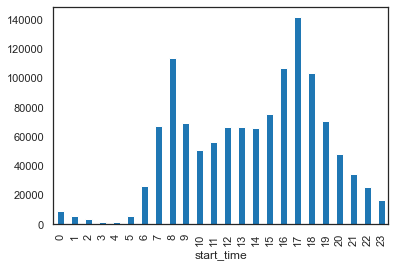

In [97]:
df['start_time'].groupby([df['start_time'].dt.hour]).count().plot(kind="bar")#.get_legend().remove()

Since we can distinguish between weekdays and weekend days, we are plotting all 7 days of the week here

Text(0.5, 1.0, 'Monday')

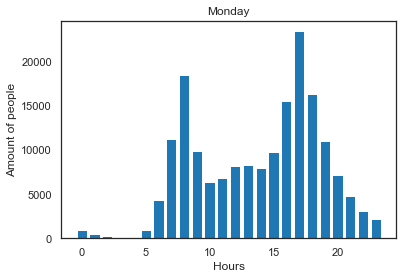

In [98]:
#Monday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Monday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Monday')

Text(0.5, 1.0, 'Tuesday')

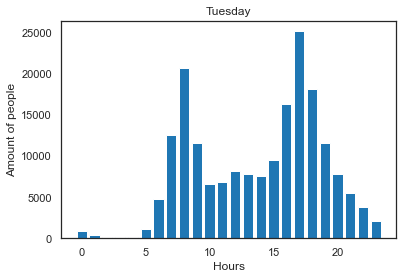

In [99]:
#Tuesday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Tuesday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Tuesday')

Text(0.5, 1.0, 'Wednesday')

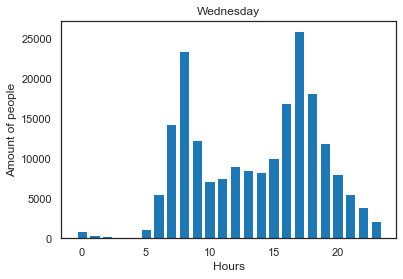

In [100]:
#Wednesday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Wednesday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Wednesday')

Text(0.5, 1.0, 'Thursday')

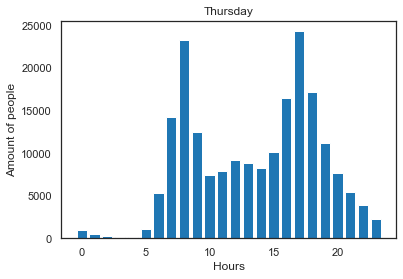

In [101]:
#Thursday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Thursday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Thursday')

Text(0.5, 1.0, 'Friday')

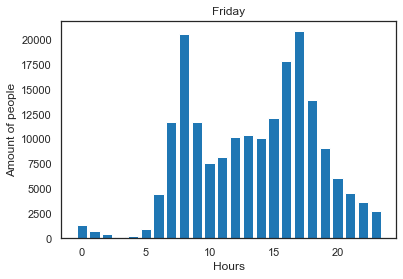

In [102]:
#Friday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Friday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Friday')

Text(0.5, 1.0, 'Saturday')

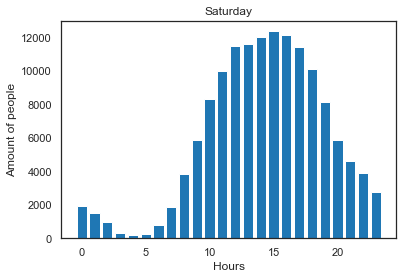

In [103]:
#Saturday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Saturday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Saturday')

Text(0.5, 1.0, 'Sunday')

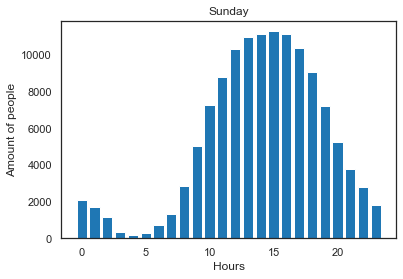

In [104]:
#Sunday
plt.bar(df_hourly_amount_per_day['Period'],df_hourly_amount_per_day['Sunday'])
plt.xlabel('Hours')
plt.ylabel('Amount of people')
plt.title('Sunday')

And now we can also between weekdays and weekend days, we are plotting all 7 days of the week here

Text(0.5, 1.0, 'Amount of people riding bluebikes per month')

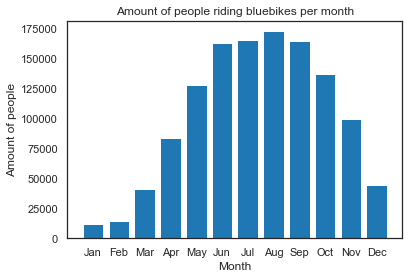

In [105]:
plt.bar(df_monthly_amount['Month'],df_monthly_amount['Amount'])
plt.xlabel('Month')
plt.ylabel('Amount of people')
plt.title('Amount of people riding bluebikes per month')

Now that we have our dataframe with values assigned to the minutes, we can use those to create 3 individual Plots.

Text(0, 0.5, 'Amount of people')

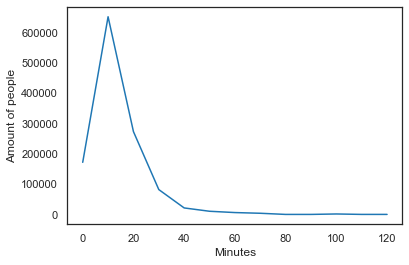

In [106]:
plt.plot(df_all_minutes['unique_minutes'],df_all_minutes['people'])
plt.xlabel('Minutes')
plt.ylabel('Amount of people')

Text(0, 0.5, 'Amount of people')

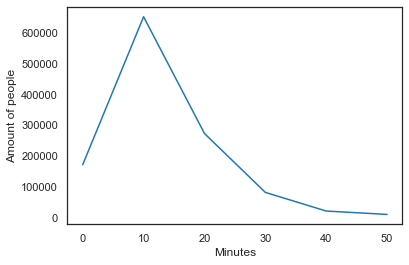

In [107]:
plt.plot(df_big_minutes['unique_minutes'],df_big_minutes['people'])
plt.xlabel('Minutes')
plt.ylabel('Amount of people')

Text(0, 0.5, 'Amount of people')

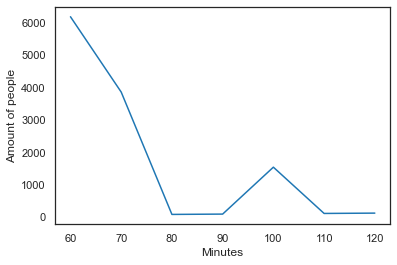

In [108]:
plt.plot(df_small_minutes['unique_minutes'],df_small_minutes['people'])
plt.xlabel('Minutes')
plt.ylabel('Amount of people')

In order to create a visualization of the stations, we have decided to represent them using a map.

Since we won't go into detail what exactly happens with the methods used,we refer to the following link:

https://towardsdatascience.com/exploring-and-visualizing-chicago-transit-data-using-pandas-and-bokeh-part-ii-intro-to-bokeh-5dca6c5ced10

In [109]:
import math
from ast import literal_eval

def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [110]:
top_left = '(42.41568810349132, -71.15337356574248)'
bottom_right = '(42.308814794642046, -70.9677292096557)'

In [111]:
merc(top_left)

(-7920757.313562025, 5223452.331299398)

In [112]:
merc(bottom_right)

(-7900091.4783737995, 5207351.240481618)

In [113]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

tile_provider = get_provider(CARTODBPOSITRON)

p = figure(x_range=(-7920757.313562025, -7900091.4783737995), y_range=(5223452.331299398, 5207351.240481618),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

output_notebook()

# show(p)

Loading BokehJS ...

In [114]:
df_stations = df_stations.drop(df_stations[df_stations['start_station_id'] == 158].index)
df_stations = df_stations.drop(df_stations[df_stations['start_station_id'] == 153].index)

In [115]:
df_map_stations = df_stations

In [116]:
df_map_stations.sort_values(['start_station_longitude'], axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,amout_of_trips_per_station,start_coordinates,distance_center_(km)
177,208,Oak Square - 615 Washington St,42.350570,-71.166491,192,"(42.35057, -71.166491)",9.005604
150,174,Washington St at Brock St,42.349005,-71.160411,999,"(42.34900494405213, -71.1604106426239)",8.532756
151,175,Brighton Center,42.348949,-71.150272,1971,"(42.34894857235593, -71.15027189254761)",7.708726
176,207,Market St at Faneuil St,42.354802,-71.150250,183,"(42.35480179069945, -71.15025043487549)",7.626228
32,37,New Balance - 20 Guest St.,42.357402,-71.147782,1310,"(42.357402, -71.147782)",7.404767
...,...,...,...,...,...,...,...
123,135,ID Building East,42.344827,-71.028664,3405,"(42.344827, -71.028664)",2.972423
178,209,Chelsea St at Saratoga St,42.379803,-71.027448,29,"(42.37980321246644, -71.02744817733765)",3.312093
133,146,Day Boulevard,42.336448,-71.023739,2987,"(42.336448, -71.023739)",3.879505
179,210,Bennington St at Byron St,42.383378,-71.016120,43,"(42.38337841883669, -71.01612031481636)",4.289932


In [117]:
df_map_stations.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,amout_of_trips_per_station,start_coordinates,distance_center_(km)
0,1,18 Dorrance Warehouse,42.387151,-71.075978,74,"(42.387151, -71.075978)",3.319275
1,3,Colleges of the Fenway,42.340021,-71.100812,4665,"(42.340021, -71.100812)",4.192547
2,4,Tremont St. at Berkeley St.,42.345392,-71.069616,8922,"(42.345392, -71.069616)",1.923611
3,5,Northeastern U / North Parking Lot,42.341814,-71.090179,7045,"(42.341814, -71.090179)",3.361583
4,6,Cambridge St. at Joy St.,42.361174,-71.065142,11635,"(42.361174, -71.065142)",0.595103


In [118]:
def makestr(x):
    return (str(x))

In [119]:
df_map_stations['str_coords'] = df_map_stations['start_coordinates'].apply(lambda x: makestr(x))

In [120]:
df_map_stations['coords_x'] = df_map_stations['str_coords'].apply(lambda x: merc(x)[0])
df_map_stations['coords_y'] = df_map_stations['str_coords'].apply(lambda x: merc(x)[1])

In [121]:
df_map_stations.head(1)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,amout_of_trips_per_station,start_coordinates,distance_center_(km),str_coords,coords_x,coords_y
0,1,18 Dorrance Warehouse,42.387151,-71.075978,74,"(42.387151, -71.075978)",3.319275,"(42.387151, -71.075978)",-7.912142e+06,5.219150e+06


In [122]:

p = figure(x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)
p.circle(x = df_map_stations['coords_x'],
         y = df_map_stations['coords_y'])
output_notebook()
# show(p)

Loading BokehJS ...

In [123]:
df_map_stations.drop(['start_station_id','start_station_name','start_station_latitude','start_station_longitude','str_coords'], axis=1, inplace=True)

In [124]:
df_map_stations.head(1)

,amout_of_trips_per_station,start_coordinates,distance_center_(km),coords_x,coords_y
0,74,"(42.387151, -71.075978)",3.319275,-7.912142e+06,5.219150e+06


In [125]:
Merged = df_map_stations

In [126]:
Merged['circle_sizes'] = Merged['amout_of_trips_per_station'] / 1000

In [127]:
# range bounds supplied in web mercator coordinates
p = figure(x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)
p.circle(x=Merged['coords_x'],
         y=Merged['coords_y'], 
         size=Merged['circle_sizes'],
         line_color="#FF0000", 
         fill_color="#FF0000",
         fill_alpha=0.05)
    
output_notebook()
show(p)

Loading BokehJS ...

###### screenshot of the map:

![GitLab home](Station_Map_trips.png)

### 1.5) Clustering

In [128]:
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

613786

In [129]:
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

306893

In [130]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

153446

In [131]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

76723

In [132]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

38361

In [133]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

19180

In [134]:
df_cluster.drop(['level_0'], axis=1, inplace=True)
df_cluster = df_cluster.drop(df_cluster[df_cluster.index % 2 == 0].index)
df_cluster = df_cluster.reset_index()
len(df_cluster)

9590

In [135]:
df_cluster.head(1)

,level_0,index,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,...,start_hour,weekday_start,weekday_end,true_monday,true_tuesday,true_wednesday,true_thursday,true_friday,true_saturday,true_sunday
0,1,133,2016-01-01 15:37:34,2016-01-01 15:41:59,178,68,MIT Pacific St at Purrington St,Central Square at Mass Ave / Essex St,1534,Subscriber,...,0,Friday,Friday,False,False,False,False,True,False,False


We can see that over time our dataframe has become quite feature rich

But for clustering we can only use a handful of features, therefore the following columns need to be dropped:

`start_time, end_time:` we use the start hour and duration of a trip instead

`start_station_id, end_station_id, start_station_name, end_station_name:` hold no valuable information for clustering

`bike_id:` we are focusing on trips and not the different bikes

`start_coordinates, end_coordinates:` can not be used for clustering as the algorithms can not know what these coordinates mean - instead we are using start_distance_center and end_distance_center

Drops for all trips:

In [136]:
# df_cluster.drop(['Unnamed: 0.1','Unnamed: 0','start_time','end_time','start_station_id','end_station_id','start_station_name','end_station_name','bike_id','start_coordinates','end_coordinates','weekday_end'], axis=1, inplace=True)

Drops for 9500 trips:

In [137]:
df_cluster.drop(['index','level_0','start_time','end_time','start_station_id','end_station_id','user_type','start_station_name','end_station_name','bike_id','start_coordinates','end_coordinates','weekday_end'], axis=1, inplace=True)

In [138]:
df_cluster.drop(["true_monday","true_tuesday","true_wednesday","true_thursday","true_friday","true_saturday","true_sunday"], axis=1, inplace=True)

Now we can see the 7 remaining features

In [139]:
df_cluster.head(1)

,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start
0,0.628436,265.0,8.53724,3.568588,3.751808,0,Friday


We can expect to find some interesting clusters with the features above.<br>
With `distance_km` we can differntiate long from short trips which should be interesting in combination with `start_distance_center,end_distance_center`<br>
`start_distance_center,end_distance_center` can inform us about the relative start and end location of a trip.<br>
`speed_kmh` should be informative as well. A commute trip can be expected to be fast and a tourist/casual is more likely to ride slower.<br> 
We have seen in 1.4 that during week days we can observe peek usage at 8am and 5pm - we can expect these to be commuting trips. With the `start_hour` feature we hope to find these pattern in a cluster. <br>
Furthermore we have observed that peek usage during the week is much higher than on weekends - we should be able to highlight this with the feature `weekday_start`.

To be able to work with the weekday_start feature we have to format the strings to ints:

In [140]:
df_cluster['weekday_start'] = df_cluster['weekday_start'].replace(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],[0,1,2,3,4,5,6])

In [141]:
df_cluster.head()

,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start
0,0.628436,265.0,8.537240,3.568588,3.751808,0,4
1,5.686696,1539.0,13.302214,7.793473,2.911715,1,5
2,3.697625,1108.0,12.013944,3.969831,0.747467,2,5
3,0.836161,247.0,12.186956,3.969831,3.568588,0,6
4,0.931580,361.0,9.289995,3.751808,4.682531,2,6


We have tried to leave some features out and keep others, the following code is just for quick enabling/disabling of features:

In [142]:
# df_cluster.drop(['duration_sec'], axis=1, inplace=True)
# df_cluster.drop(['speed_kmh'], axis=1, inplace=True)
# df_cluster.drop('start_hour', axis=1, inplace=True)
# df_cluster.drop("user_type", axis=1, inplace=True)
# df_cluster.drop('weekday_start', axis=1, inplace=True) 
# df_cluster.drop(['start_distance_center','end_distance_center'], axis=1, inplace=True) 

In [143]:
# df_cluster['start_hour'] = df_cluster['start_hour'].replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],[0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,2,2,2,0,0,0,0,0])
## 0 => any hour that is not rush hour <br>
## 1 => hours 7,8,9 <br>
## 2 => hours 16,17,18

Now we can get to clustering:<br>
For the unsupervised learing case we have decided to use the K-Means algorithm.<br>
Please refer to the report for reasoning.<br>
Thanks to the K-Means versatility we were able to use most of the code from workshop 11 - Introduction to Unsupervised Learning and Clustering

In [144]:
X = df_cluster

In order to use the K-Means algorithm we have to scale the data by normalizing it:

In [145]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head(10)

,distance_km,duration_sec,speed_kmh,start_distance_center,end_distance_center,start_hour,weekday_start
0,-1.026324,-0.822601,-0.262541,0.307228,0.423779,-0.897088,0.639895
1,3.134306,1.010169,1.004455,2.690473,-0.051430,0.260639,1.167638
2,1.498212,0.390135,0.661907,0.533568,-1.275660,1.418367,1.167638
3,-0.855462,-0.848496,0.707910,0.533568,0.320139,-0.897088,1.695381
4,-0.776975,-0.684496,-0.062385,0.410582,0.950252,1.418367,1.695381
5,-0.365900,-0.573724,0.595568,-0.484496,0.174423,-0.897088,-1.471077
6,-1.034753,-0.803899,-0.403980,1.222475,0.905717,1.418367,-1.471077
7,-0.311496,-0.729092,1.811180,0.161915,-0.620413,0.260639,-0.943334
8,-0.155988,-0.340672,0.158111,-0.063312,0.560947,1.418367,-0.943334
9,-0.660663,-0.786636,1.009137,1.367878,1.624875,-0.897088,-0.943334


In [146]:
df_scaled = X_scaled_df

In [147]:
from sklearn.cluster import KMeans

To find out how many clusters we should expect we are applying two methods here: <br>
1. Expert knowledge 
2. Residual loss - elbow method <br>

After working with the trip data extensively we have a rough idea of how many trip archetypes we can expect. <br>
The features we have access to make location related data very limited, therefore we can only expect to see clusters for inner city trips, outer city trips and trips that connect inner and outer city. <br>
Furthermore do we expect to have mostly two main users: <br>
 - commuters (they would be faster und ride during weekdays)
 - casuals/tourists (they would be slower and ride during weekdays and weekends)<br>
Combining these factors we do not expect to see more than 10 clusters.

For good measure we will still perform the Residual loss / Elbow method with a max k of 50:

In [148]:
k_max = 50

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

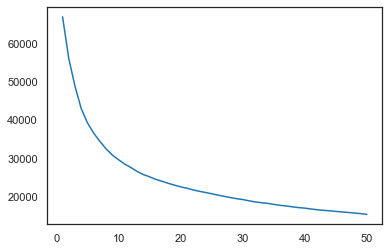

In [149]:
plt.plot(clusters, losses)
plt.show()

(0.0, 20.0)

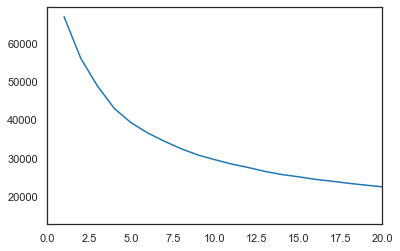

In [150]:
plt.plot(clusters, losses)
plt.xlim([0,20])

Looking at the plot we can say that 4 to 8 clusters are to be expected. <br>
Therfore we are running the algoruithm 5 times with n_clusters going from 4 to 8.  <br>
Then we can inspect the 5 results and settle on a final number of clusters. 

In [151]:
numbers = ["zero", "one", "two", "three","four","five","six","seven"]

In [152]:
#numbers_4 = ["zero", "one", "two", "three"]
#four_means = KMeans(n_clusters=4, random_state = 4)
#four_means.fit(X_scaled)
#df_scaled["clusters"] = four_means.predict(X_scaled)
#df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
#plot_4 = sns.pairplot(data=df_scaled, hue="clusters", hue_order = numbers_4)

In [153]:
#numbers_5 = ["zero", "one", "two", "three","four"]
#five_means = KMeans(n_clusters = 5, random_state = 5)
#five_means.fit(X_scaled)
#df_scaled["clusters"] = five_means.predict(X_scaled)
#df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
#plot_5 = sns.pairplot(data=df_scaled, hue="clusters",hue_order = numbers_5)

In [154]:
#numbers_6 = ["zero", "one", "two", "three","four","five"]
#six_means = KMeans(n_clusters=6, random_state = 6)
#six_means.fit(X_scaled)
#df_scaled["clusters"] = six_means.predict(X_scaled)
#df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
#plot_6 = sns.pairplot(data=df_scaled, hue="clusters",hue_order = numbers_6)

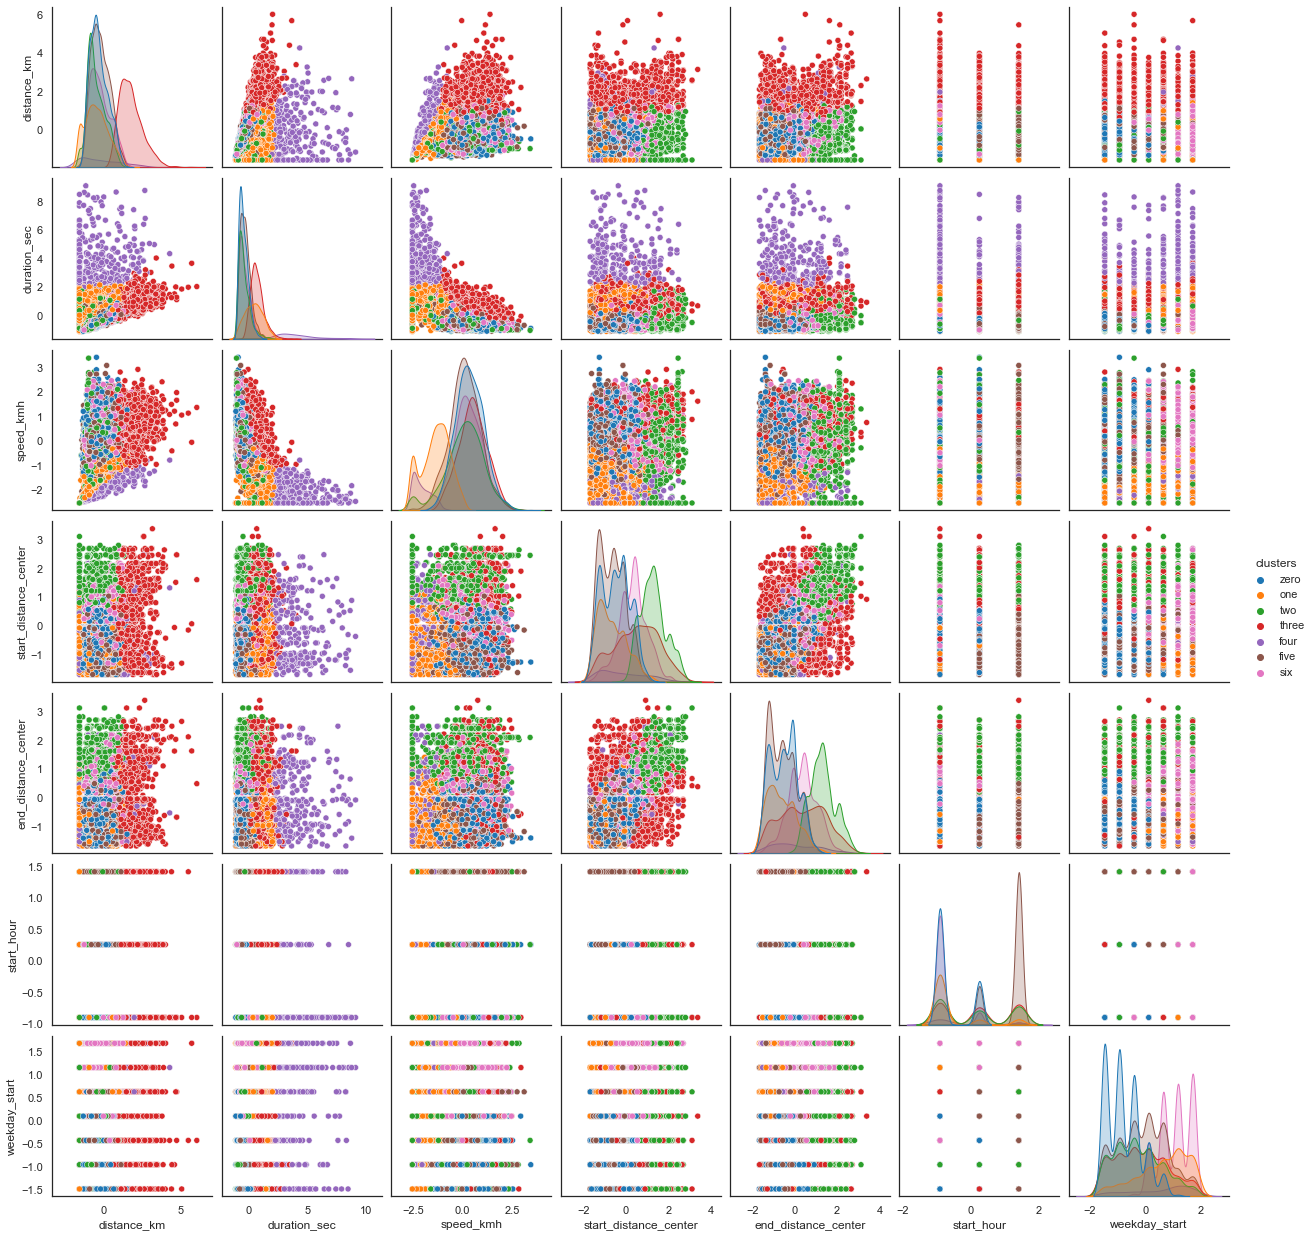

In [155]:
numbers_7 = ["zero", "one", "two", "three","four","five","six"]
seven_means = KMeans(n_clusters=7, random_state = 7)
seven_means.fit(X_scaled)
df_scaled["clusters"] = seven_means.predict(X_scaled)
df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
plot_7 = sns.pairplot(data=df_scaled, hue="clusters",hue_order = numbers_7)

In [156]:
#numbers_8 = ["zero", "one", "two", "three","four","five","six","seven"]
#eight_means = KMeans(n_clusters=8,random_state = 8)
#eight_means.fit(X_scaled)
#df_scaled["clusters"] = eight_means.predict(X_scaled)
#df_scaled["clusters"] = df_scaled["clusters"].apply(lambda x: numbers[x])
#plot_8 = sns.pairplot(data=df_scaled, hue="clusters",hue_order = numbers_8)

## Task 2 Customer Behavior Analytics:

1) Read Data
2) Organize Data
3) Visualization and feature selection
4) Regression

### 2.1) Read Data

We are starting with the tripdata dataframe (initialized when we first read the csv files) 

In [157]:
# convert datetime type
tripdata['start_time'] = pd.to_datetime(tripdata['start_time'])

In [158]:
# check that import worked
tripdata

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh
0,2016-01-01 00:08:07.000,2016-01-01 00:40:26.000,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1939.000,4.312426
1,2016-01-01 00:08:19.000,2016-01-01 00:40:27.000,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1121,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1928.000,4.337030
2,2016-01-01 00:10:15.000,2016-01-01 00:40:29.000,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,474,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1814.000,4.609589
3,2016-01-01 00:10:22.000,2016-01-01 00:40:11.000,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1504,Subscriber,"(42.349673, -71.077303)","(42.347241, -71.105301)",2.322721,1789.000,4.674004
4,2016-01-01 00:15:36.000,2016-01-01 00:31:17.000,36,67,Boston Public Library - 700 Boylston St.,MIT at Mass Ave / Amherst St,913,Customer,"(42.349673, -71.077303)","(42.3581, -71.093198)",1.609739,941.000,6.158407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236198,2016-12-31 23:01:46.254,2016-12-31 23:14:20.625,8,33,Union Square - Brighton Ave at Cambridge St,Kenmore Square,230,Subscriber,"(42.353334, -71.137313)","(42.348706, -71.097009)",3.360358,754.371,16.036259
1236199,2016-12-31 23:14:21.233,2016-12-31 23:18:03.185,190,6,Nashua Street at Red Auerbach Way,Cambridge St at Joy St,1420,Subscriber,"(42.36559770612416, -71.06424808502197)","(42.361174, -71.065142)",0.496874,221.952,8.059157
1236200,2016-12-31 23:15:38.580,2016-12-31 23:24:43.019,33,36,Kenmore Square,Copley Square - Dartmouth St at Boylston St,230,Subscriber,"(42.348706, -71.097009)","(42.349673, -71.077303)",1.627250,544.439,10.759881
1236201,2016-12-31 23:20:35.796,2016-12-31 23:27:58.583,90,141,Lechmere Station at Cambridge St / First St,Kendall Street,74,Subscriber,"(42.370677, -71.076529)","(42.36356015842989, -71.08216792345047)",0.916903,442.787,7.454714


We work with the weather_data dataframe (initialized when we first read the csv files)

In [159]:
# convert date time type
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

### 2.2) Organize Data

We set the start and end date because just 2016 data is relevant and create a new dataframe with the seletected data.

In [160]:
start = pd.to_datetime(datetime(year=2016, month=1, day=1))
end = pd.to_datetime(datetime(year=2017, month=1, day=1))

# select weather data from 2016
weather_data_16 = weather_data[(weather_data["date_time"]>=start)&(weather_data["date_time"]<=end)]

Next we organize the dataframe by sorting it and dropping rows with duplicates.

In [161]:
# convert precipitation type
weather_data_16['precip'] = weather_data_16['precip'].apply(np.int64)

# sort weather data by timestamp
weather_data_16 = weather_data_16.sort_values(by=['date_time'], ascending=True)

# drop duplicate rows
weather_data_16 = weather_data_16.drop_duplicates(subset='date_time', keep='first')

# reset weather data index
weather_data_16.index = range(8251)

In [162]:
weather_data_16

,date_time,max_temp,min_temp,precip
0,2016-01-01 00:00:00,5.6,5.6,0
1,2016-01-01 01:00:00,5.0,5.0,0
2,2016-01-01 02:00:00,5.0,5.0,0
3,2016-01-01 03:00:00,4.4,4.4,0
4,2016-01-01 04:00:00,4.4,4.4,0
...,...,...,...,...
8246,2016-12-31 20:00:00,1.7,1.7,0
8247,2016-12-31 21:00:00,1.7,1.7,0
8248,2016-12-31 22:00:00,2.2,2.2,0
8249,2016-12-31 23:00:00,3.3,3.3,0


#### Focus on most popular station

As we know from Task 1 (see 1.3) for more information), the most popular rental station by outgoing trips in the network is "MIT at Mass Ave / Amherst St" (station_id: 67).

From now on, for the demand prediction, we focus on the most popular station, so we just look at trips from station 67.

In [163]:
# select just the outgoing trips from station 67
tripdata67 = tripdata.where(lambda x: (x.start_station_id == 67), axis = 0)

# convert start time type
tripdata67['start_time'] = pd.to_datetime(tripdata67['start_time'])

We create a new dataframe with our tripdata, where we count the outgoing trips from station 67 per hour, drop all other data and adjust the beginning and end times so it is easier to merge the trip data with the weather data later. 

In [164]:
# set hourly Dataframe
tripdata67_hourly = tripdata67.set_index('start_time')

# count outoing trips per hour
tripdata67_hourly = tripdata67_hourly.resample('H').count()

# drop unnecessary columns 
tripdata67_hourly = tripdata67_hourly.drop('start_station_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('end_station_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('start_station_name', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('end_station_name', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('bike_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('user_type', axis=1)
tripdata67_hourly.rename(columns = {'end_time':'trips_out'}, inplace = True)

# reset index
tripdata67_hourly = tripdata67_hourly.reset_index()

# renaming start_time column (to date_time)
tripdata67_hourly.rename(columns = {'start_time':'date_time'}, inplace = True)

# setting index to new range that new data can be added
tripdata67_hourly.index = range(8, 8782)

# create data for 'front' dataframe
data = [[pd.to_datetime('2016-01-01 00:00:00'),0],
        [pd.to_datetime('2016-01-01 01:00:00'),0],
        [pd.to_datetime('2016-01-01 02:00:00'),0],
        [pd.to_datetime('2016-01-01 03:00:00'),0],
        [pd.to_datetime('2016-01-01 04:00:00'),0],
        [pd.to_datetime('2016-01-01 05:00:00'),0],
        [pd.to_datetime('2016-01-01 06:00:00'),0],
        [pd.to_datetime('2016-01-01 07:00:00'),0]]

# create data for 'rear' dataframe
data2 = [[pd.to_datetime('2016-12-31 22:00:00'),0],
         [pd.to_datetime('2016-12-31 23:00:00'),0],
         [pd.to_datetime('2017-01-01 00:00:00'),0]]
 
# create help dataframes
dfh = pd.DataFrame(data, range(8), columns=['date_time', 'trips_out'])
dfh2 = pd.DataFrame(data2, range(8782, 8785), columns=['date_time', 'trips_out'])

# add help dataframes to main dataframe
tripdata67_hourly = tripdata67_hourly.append(dfh, ignore_index=False)
tripdata67_hourly = tripdata67_hourly.append(dfh2, ignore_index=False)

# sort main dataframe
tripdata67_hourly = tripdata67_hourly.sort_index()

In [165]:
tripdata67_hourly

,date_time,trips_out,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh
0,2016-01-01 00:00:00,0,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,0,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 02:00:00,0,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 03:00:00,0,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 04:00:00,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8780,2016-12-31 20:00:00,1,1.0,1.0,1.0,1.0,1.0
8781,2016-12-31 21:00:00,2,2.0,2.0,2.0,2.0,2.0
8782,2016-12-31 22:00:00,0,NaN,NaN,NaN,NaN,NaN
8783,2016-12-31 23:00:00,0,NaN,NaN,NaN,NaN,NaN


#### MERGE TRIP AND WEATHER DATA

We merge the hourly trip data with the weather data into one dataframe. Afterwards we fill any NaN values that might occur because of missing entries in the weather data.

In [166]:
# create help arrays for column values
data_max = []
data_min = []
data_pre = []

# iterating through dataframe 
# count_w is the current number of columns where we have weather entries
count_w = 0
for i in range(8785):
    # if current timpstamp of trip data and weather data match, add weather values, otherwise add None 
    if tripdata67_hourly['date_time'].iloc[i] == weather_data_16['date_time'].iloc[count_w]:
        data_max.append(weather_data_16['max_temp'].iloc[count_w])
        data_min.append(weather_data_16['min_temp'].iloc[count_w])
        data_pre.append(weather_data_16['precip'].iloc[count_w])
        # if we found weather data, increase weather counter
        count_w = count_w + 1
    else:
        data_max.append(None)
        data_min.append(None)
        data_pre.append(None)

# convert help arrays to series
data_max = pd.Series(data_max)
data_min = pd.Series(data_min)
data_pre = pd.Series(data_pre)

# add new columns to trip data dataframe
tripdata67_hourly['max_temp'] = data_max
tripdata67_hourly['min_temp'] = data_min
tripdata67_hourly['precip'] = data_pre

# iterate through trip data dataframe
for i in range(8785):
    # look for NaN Values and replace them
    if np.isnan(tripdata67_hourly['max_temp'].iloc[i]):
        if np.isnan(tripdata67_hourly['max_temp'].iloc[i+1]):
            tripdata67_hourly['max_temp'].iloc[i] = tripdata67_hourly['max_temp'].iloc[i-1]
            tripdata67_hourly['min_temp'].iloc[i] = tripdata67_hourly['min_temp'].iloc[i-1]
        else:
            tripdata67_hourly['max_temp'].iloc[i] = (tripdata67_hourly['max_temp'].iloc[i-1]+tripdata67_hourly['max_temp'].iloc[i+1])/2
            tripdata67_hourly['min_temp'].iloc[i] = (tripdata67_hourly['min_temp'].iloc[i-1]+tripdata67_hourly['min_temp'].iloc[i+1])/2
        
        tripdata67_hourly['precip'].iloc[i] = tripdata67_hourly['precip'].iloc[i-1]

In [167]:
tripdata67_hourly

,date_time,trips_out,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh,max_temp,min_temp,precip
0,2016-01-01 00:00:00,0,NaN,NaN,NaN,NaN,NaN,5.6,5.6,0.0
1,2016-01-01 01:00:00,0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,0.0
2,2016-01-01 02:00:00,0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,0.0
3,2016-01-01 03:00:00,0,NaN,NaN,NaN,NaN,NaN,4.4,4.4,0.0
4,2016-01-01 04:00:00,0,NaN,NaN,NaN,NaN,NaN,4.4,4.4,0.0
...,...,...,...,...,...,...,...,...,...,...
8780,2016-12-31 20:00:00,1,1.0,1.0,1.0,1.0,1.0,1.7,1.7,0.0
8781,2016-12-31 21:00:00,2,2.0,2.0,2.0,2.0,2.0,1.7,1.7,0.0
8782,2016-12-31 22:00:00,0,NaN,NaN,NaN,NaN,NaN,2.2,2.2,0.0
8783,2016-12-31 23:00:00,0,NaN,NaN,NaN,NaN,NaN,3.3,3.3,0.0


#### Add features

We select a few features that we thought give a good insight into the nature of the bike trip data and add the respective columns.

In [168]:
# add average temperature column
tripdata67_hourly['avg_temp'] = (tripdata67_hourly['max_temp'] + tripdata67_hourly['min_temp'])/2

# add weekday column
tripdata67_hourly['weekday'] = tripdata67_hourly.apply(lambda x: (x.date_time.weekday()), axis=1)

# add hour column
tripdata67_hourly['hour'] = tripdata67_hourly.apply(lambda x: (x.date_time.hour), axis=1)

In [169]:
tripdata67_hourly

,date_time,trips_out,start_coordinates,end_coordinates,distance_km,duration_sec,speed_kmh,max_temp,min_temp,precip,avg_temp,weekday,hour
0,2016-01-01 00:00:00,0,NaN,NaN,NaN,NaN,NaN,5.6,5.6,0.0,5.6,4,0
1,2016-01-01 01:00:00,0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,0.0,5.0,4,1
2,2016-01-01 02:00:00,0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,0.0,5.0,4,2
3,2016-01-01 03:00:00,0,NaN,NaN,NaN,NaN,NaN,4.4,4.4,0.0,4.4,4,3
4,2016-01-01 04:00:00,0,NaN,NaN,NaN,NaN,NaN,4.4,4.4,0.0,4.4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8780,2016-12-31 20:00:00,1,1.0,1.0,1.0,1.0,1.0,1.7,1.7,0.0,1.7,5,20
8781,2016-12-31 21:00:00,2,2.0,2.0,2.0,2.0,2.0,1.7,1.7,0.0,1.7,5,21
8782,2016-12-31 22:00:00,0,NaN,NaN,NaN,NaN,NaN,2.2,2.2,0.0,2.2,5,22
8783,2016-12-31 23:00:00,0,NaN,NaN,NaN,NaN,NaN,3.3,3.3,0.0,3.3,5,23


### 2.3) Visualization and feature selection

We visualize a few features to see if the data matches our expectations and if there are any obvious correlations.

#### Temperature

First we start with the average temperature (per hour) and plot it over the hole year as well as the outgoing trips per hour.

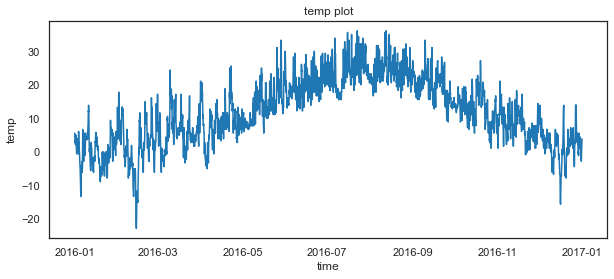

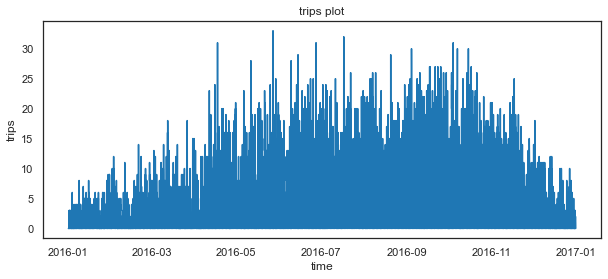

In [170]:
# average temperature visualization
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(tripdata67_hourly["date_time"],tripdata67_hourly["avg_temp"],"-")
ax.set_xlabel("time")
ax.set_ylabel("temp")
ax.set_title("temp plot")

# trips per hours visualization
fig,ax2 = plt.subplots(figsize=(10,4))
ax2.plot(tripdata67_hourly["date_time"],tripdata67_hourly["trips_out"],"-")
ax2.set_xlabel("time")
ax2.set_ylabel("trips")
ax2.set_title("trips plot")

plt.show()

Because there seems to be a correlation, we define dependent (y) and independent (x) variables for our trip demand prediction and draw the resulting scatter plot.

In [171]:
xp = tripdata67_hourly["avg_temp"]
yp = tripdata67_hourly["trips_out"]

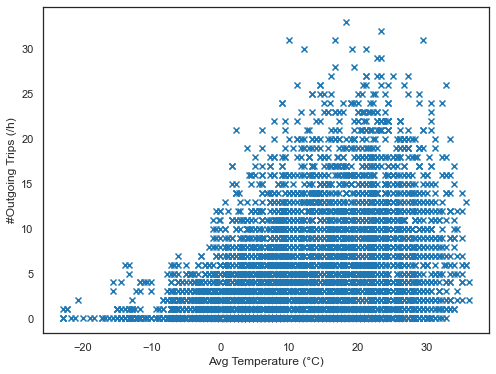

In [172]:
fig, ax = plt.subplots(figsize = (8,6))
# plotting the data
ax.scatter(xp, yp, marker='x',)
ax.set_xlabel("Avg Temperature (°C)")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()

The number of outgoing trips seems to rise up as the recorded temperature rises until ~25°C and then drops down again. So we expect a correlation but it's likely not linear.

#### Time of day

Next we look at the time of day, the trips are started, so we plot the starting hour and the number of outgoing trips.

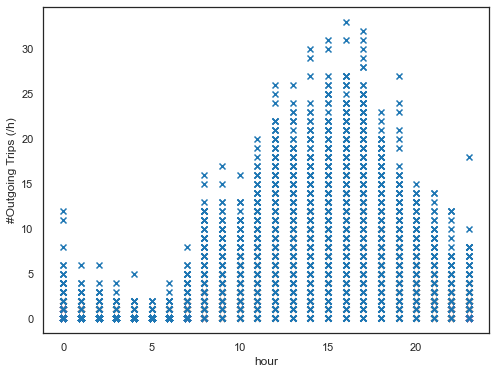

In [173]:
# define dependent (y) and independent (x) variables for trip demand prediction

xp2 = tripdata67_hourly["hour"]

yp2 = tripdata67_hourly["trips_out"]

fig, ax = plt.subplots(figsize = (8,6))
# plotting the data
ax.scatter(xp2, yp2, marker='x',)
ax.set_xlabel("hour")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')
# note: we see that a higher average temperature in an hour correlates with the number of outgoing trips
# (positive trend until +25°C, then negative)

Here we clearly see that the time of day matters but we also know that the temperature changes not only with the seasons but also depending on the time of day. Furthermore, the demand between ~10am and ~7pm is always similarly high.

#### Day of week and Precipitation

We also compared the number of outgoing trips per weekday and whether there was precipitation recorded. 

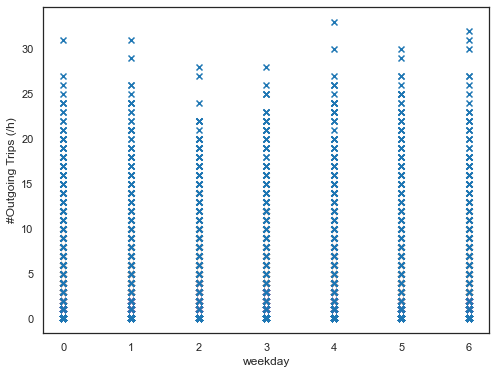

In [174]:
xp2 = tripdata67_hourly["weekday"]
yp2 = tripdata67_hourly["trips_out"]

fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(xp2, yp2, marker='x',)
ax.set_xlabel("weekday")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')

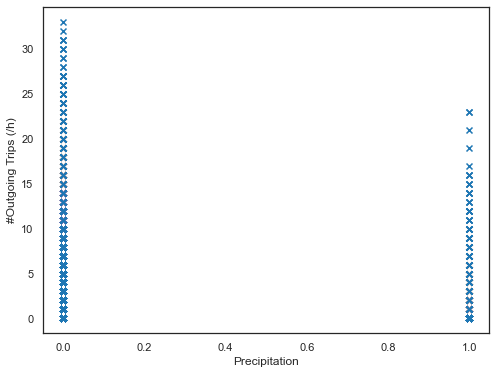

In [175]:
xp2 = tripdata67_hourly["precip"]
yp2 = tripdata67_hourly["trips_out"]

fig, ax = plt.subplots(figsize = (8,6))
# Plotting the data
ax.scatter(xp2, yp2, marker='x',)
ax.set_xlabel("Precipitation")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')

We see minor changes for the weekdays and a factor of about 2 for precipitation. But because the temperature has the most significant impact on the demand, we decided to go ahead and apply the regression algorithms to the temperature feature.  

### 2.4) Regression

#### Polynomial regression

As we already mentioned, the correlation of temperature and the number of outgoing trips doesn't appear to be linear, so we decided to start with a polynomial regression and look at different polynomial degrees.

In [176]:
# to plot a polynomial regression, we took the code from the workshop

# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    # create scaled test dataset
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # Plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # prints first 3 thetas

[5.20184949 3.16462992]


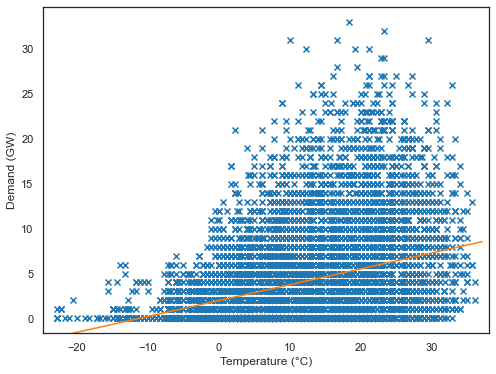

In [177]:
plot_regression_poly(x = xp, y=yp, d = 1)

[0.05836358 5.1826315  3.15975946]


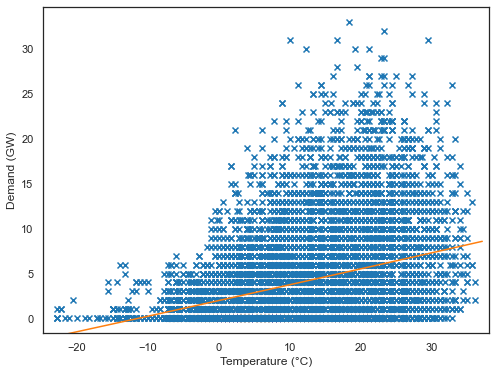

In [178]:
plot_regression_poly(x = xp, y=yp, d = 2)

[-2.4691568   0.9013659   5.76240632  3.09134447]


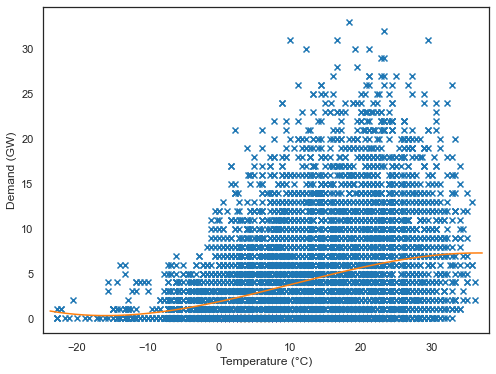

In [179]:
plot_regression_poly(x = xp, y=yp, d = 3)

[-32.63550377  -4.71398058  53.78801811   4.82321407 -26.78751996
   0.16868236   8.19837954]


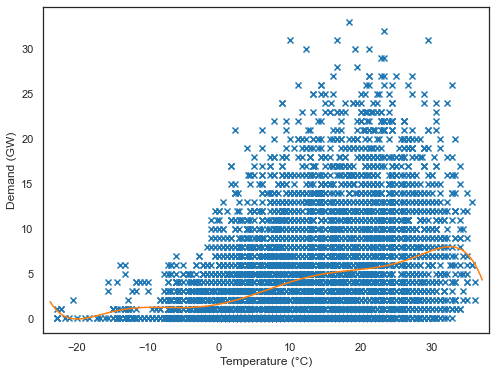

In [180]:
plot_regression_poly(x = xp, y=yp, d = 7)

Every degree from 3 up looks promising but 7 seems to have the best fit. To test this hypothesis, we will evaluate which degree fits best next by determining the mean squared error. 

#### train test split

First we split the data into a training set with the usual 30-70% ratio.

In [181]:
# splitting the data with 70-30% split
x_train, x_test, y_train, y_test = train_test_split(tripdata67_hourly["avg_temp"], tripdata67_hourly["trips_out"], test_size=0.3, random_state=42)

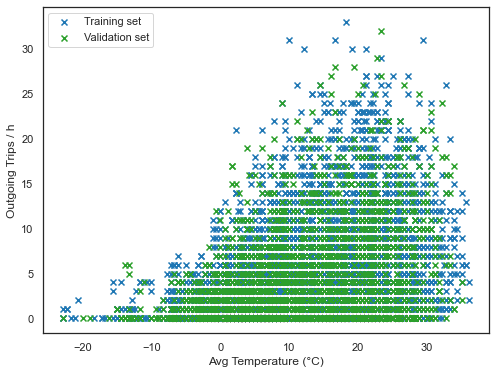

In [182]:
# plotting train and test set
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.xlabel("Avg Temperature (°C)")
plt.ylabel("Outgoing Trips / h")
plt.legend(['Training set', 'Validation set'])
plt.show()
#plt.savefig('crossvalidation.pdf', dpi = 300)

In [183]:
# to determine the mean squared error, we use code from the workshop
def ls_poly(x, y, d): #ls=lest squares
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    
    return theta

Text(0, 0.5, 'Mean squared error')

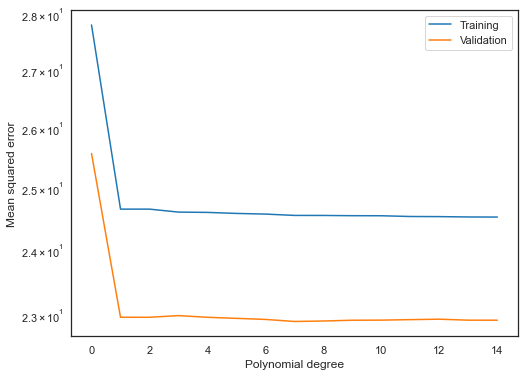

In [184]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_test = 2*(x_test - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    
maxdegree = 15
    
err_train = []
abserrtrain = []
err_cv = []
abserrcv = []
for i in range(maxdegree):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_test,i) @ theta - y_test)**2).mean())
    abserrtrain.append((abs(poly_feat(x_train,i) @ theta - y_train)).mean())
    abserrcv.append((abs(poly_feat(x_test,i) @ theta - y_test)).mean())

plt.figure(figsize = (8,6))
plt.semilogy(range(maxdegree), err_train, range(maxdegree), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

In [185]:
abserrcv[7]

3.6480385525848065

In [186]:
abserrtrain[7]

3.7059516254168154

In [187]:
err_train[7]

24.543255039508306

In [188]:
err_cv[7]

22.89632045481137

As we expected, the mean squared error for the different polynomial degrees shows us that a degree of 7 has the best outcome. We expect a absolut deviation of hour prediction of about 3.7 bikes.

#### Ridge regression

Because we want to avoid overfitting and smoothen our function, we decided to use regularization. Therefore we will perform a ridge regression as our second regression algorithm. A polynomial degree of 35 and a value for lambda of 0.4 seem a good estimate for an accurate prediction

In [189]:
deg = 35
lam = 0.4

xp = tripdata67_hourly["avg_temp"].values
yp = tripdata67_hourly["trips_out"].values

# using mostly code from the workshop to use scikits ridge regression 
# initialize model
Poly = PolynomialFeatures(degree = deg)

# fit and transform xp
X_poly = Poly.fit_transform(xp.reshape(-1,1))

model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver

model_L2.fit(X_poly, yp)
prediction = model_L2.predict(X_poly)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 0.00000000e+00  8.23465635e-02  1.54808106e-03  3.22474439e-05
  4.71089281e-07  7.19432600e-09  2.47117987e-11 -1.25939553e-12
 -8.61782034e-14 -2.57983834e-15 -7.63135113e-17 -1.81218626e-18
 -4.32838145e-20 -8.89432653e-22 -1.78905152e-23 -2.98421589e-25
 -4.31456893e-27 -2.74223545e-29  7.31491589e-31  4.25685626e-32
  1.11045406e-33  1.45302807e-35 -4.72443236e-37 -4.68297448e-38
 -2.48853954e-39 -1.07867906e-40 -4.21864233e-42 -1.54523679e-43
 -5.41265213e-45 -1.83399249e-46 -6.05844988e-48 -1.96125413e-49
 -6.24562634e-51 -1.96196740e-52 -6.09286142e-54 -1.87365629e-55] 
Intercept  2.524648615203701


In [190]:
# function for plotting

def plot_scikit_output (x, y, fitted_model):
    
    min_x, max_x = x.min(), x.max()
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, fitted_model.predict(xt0_poly), 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Outgoing trips")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)

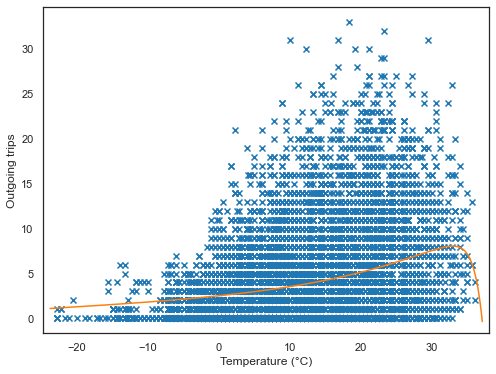

In [191]:
plot_scikit_output (xp, yp, model_L2)

To evaluate the performance of the ridge regression, we look how it's mean squared error changes depending on different lambda values.

In [192]:
exp1 = -4
exp2 = 5

# mostly code from the workshop to evaluate the regression performance 
def plot_L2_regression_performance (x, y, deg):

    err_train = []
    err_cv = []
    
    x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

    for alpha in np.logspace(exp1, exp2,100):

        # create poly features
        poly_reg = PolynomialFeatures (degree = deg)
        X_train_poly = poly_reg.fit_transform(x_train.reshape(-1,1))
        X_test_poly = poly_reg.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L2 = Ridge(alpha = alpha, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test_poly), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(exp1,exp2,100), err_train, np.logspace(exp1,exp2,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha)")
    plt.ylabel("Mean squared error")
    plt.show()

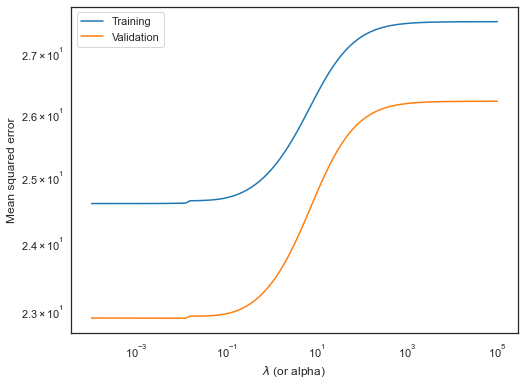

In [193]:
plot_L2_regression_performance(xp,yp,deg)

We see that the mean squared error of the ridge regression is similar to the mse of the regular polynomial regression up to a value of lambda of 1. So our determined lambda value of 0.4 results in a not too complex model as well as a training loss that is not too large.

#### Radial Basis Function

Furthermore we briefly looked at the radial basis function as another regression algorithm, but it turned out to not give as satisfying results as we hoped for.

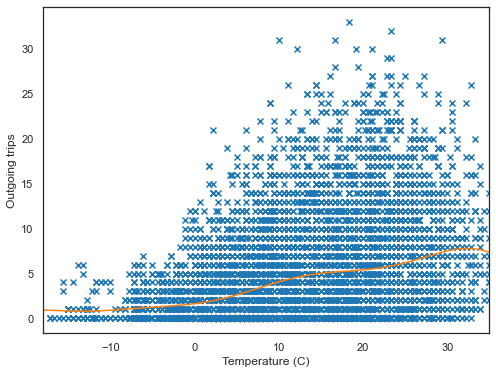

In [194]:
# using code from the workshops to realize the RBF
# create RBF features
def rbf_feat(x, mu, sig):
    return np.hstack([np.exp(-(x[:,None] - mu)**2/(2*sig**2)), np.ones((len(x),1))])

def plot_regression_rbf(theta, mu, sig):
    xt = np.linspace(-20,35, 400)
    yt = rbf_feat(xt, mu, sig) @ theta
    
    plt.figure(figsize = (8,6))
    plt.scatter(tripdata67_hourly["avg_temp"], tripdata67_hourly["trips_out"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt, yt, 'C1')
    plt.xlabel("Temperature (C)")
    plt.ylabel("Outgoing trips")
    plt.xlim([-18,35])
    plt.ylim(ylim)                  

def train_rbf(x, y, n_rbf):
    min_x, max_x = x.min(), x.max()
    sig = (max_x - min_x)/(n_rbf-1)
    mu = np.linspace(min_x, max_x, n_rbf-1)
    
    Phi = rbf_feat(x, mu, sig)
    theta = np.linalg.solve(Phi.T @ Phi, Phi.T @ y)
    return theta, mu, sig
    
x = tripdata67_hourly["avg_temp"].values
plot_regression_rbf(*train_rbf(xp, yp, 9))